# <u>Projet 8 : Déployez un modèle de scoring</u>

### Mission:
- Construction d'une partie de la chaîne de traitement de données (chargement des données, préparation du modèle, extraction des features et réduction de dimensions de type ACP) en PySpark. 
- Déploiement dans un environnement Big Data. 

### 1. Démarrage de la session Spark

In [1]:
# L'exécution de cette cellule démarre l'applicaton Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1691488269766_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u>:

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1691488269766_0001,pyspark,idle,Link,Link,None,✔


### 2.Installation des packages

Les packages nécessaires ont été installés via l'étape de **bootstrap** à l'instanciation du serveur. 

### 3. Import des librairies

In [3]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4. Définition des PATH pour charger les images et enregistrer les résultats

In [4]:
PATH = 's3://p8-data-evaro'
PATH_Data = PATH+'/Test1'
PATH_Result = PATH+'/Results'
print('PATH:'+\
     PATH+'\nPATH_Data:'+\
     PATH_Data+'\nPATH_Result:'+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:s3://p8-data-evaro
PATH_Data:s3://p8-data-evaro/Test1
PATH_Result:s3://p8-data-evaro/Results

### 5. Traitement des données

#### a. Chargement des données

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8-data-evar...|2023-07-21 11:29:21|  5608|[FF D8 FF E0 00 1...|
|s3://p8-data-evar...|2023-07-21 11:29:21|  5484|[FF D8 FF E0 00 1...|
|s3://p8-data-evar...|2023-07-21 11:29:21|  5420|[FF D8 FF E0 00 1...|
|s3://p8-data-evar...|2023-07-21 11:29:21|  5397|[FF D8 FF E0 00 1...|
|s3://p8-data-evar...|2023-07-21 11:29:21|  5375|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

On ne conserve que le **path** de l'image et on ajoute une colonne contenant les labels de chaque image. 

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------+----------+
|path                                         |label     |
+---------------------------------------------+----------+
|s3://p8-data-evaro/Test1/Strawberry/2_100.jpg|Strawberry|
|s3://p8-data-evaro/Test1/Orange/r_159_100.jpg|Orange    |
|s3://p8-data-evaro/Test1/Orange/19_100.jpg   |Orange    |
|s3://p8-data-evaro/Test1/Orange/r_30_100.jpg |Orange    |
|s3://p8-data-evaro/Test1/Orange/183_100.jpg  |Orange    |
+---------------------------------------------+----------+
only showing top 5 rows

None

On affiche le nombre d'images pour chaque catégorie (label). 

In [8]:
images.groupBy('label').count().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|     label|count|
+----------+-----+
|    Orange|    5|
|Strawberry|    5|
|      Kiwi|    5|
|    Papaya|    5|
|    Banana|    5|
+----------+-----+

#### b) Préparation du modèle 

In [9]:
model = MobileNetV2(weights='imagenet',
                   include_top=True,
                   input_shape=(224,224,3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

In [10]:
new_model = Model(inputs=model.input,
                 outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
broadcast_weight = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [13]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weight.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### c) Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF

In [14]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1691488269766_0001/container_1691488269766_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

#### d) Exécutions des actions d'extractions de features

In [15]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://p8-data-evaro/Results

In [18]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 6. Chargement des données enregistrées et validation du résultat

In [19]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                           features
0        s3://p8-data-evaro/Test1/Orange/183_100.jpg  ...  [0.05604238, 0.0, 0.004987055, 0.0, 0.0, 0.0, ...
1  s3://p8-data-evaro/Test1/Strawberry/r_110_100.jpg  ...  [0.82512057, 1.5376939, 0.007113155, 0.0035538...
2         s3://p8-data-evaro/Test1/Orange/19_100.jpg  ...  [0.34114096, 0.0, 0.0, 0.0, 0.025403762, 0.0, ...
3   s3://p8-data-evaro/Test1/Strawberry/r_18_100.jpg  ...  [2.4608047, 0.0, 0.0, 0.0, 0.34758165, 0.0, 0....
4      s3://p8-data-evaro/Test1/Strawberry/2_100.jpg  ...  [1.4756441, 0.0, 0.0, 0.0, 0.018280273, 0.4080...

[5 rows x 3 columns]

In [21]:
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [22]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(25, 3)

### 7. Réduction de dimensions par ACP

#### a. Préparation des données

Notre dataframe étant de type Pandas DataFrame, nous allons le convertir, dans un premier temps, en un Spark DataFrame.
La colonne "features" du dataframe `df` contient une liste de valeurs de type "float". Il faut les convertir en vecteurs denses afin de faciliter le traitement des données dans Spark.

In [23]:
from pyspark.ml.linalg import Vectors
df["features"] = df["features"].apply(lambda x: Vectors.dense(x))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# Conversion du dataframe Pandas en un dataframe Spark
spark_df = spark.createDataFrame(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### b. Normalisation des données

Il est nécessaire de normaliser les variables afin d'avoir une ACP centrée et normée avec StandardScaler().

In [25]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler

# Création de l'instance StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Application de l'instance et du transformeur résultant
scalerModel = scaler.fit(spark_df)
scaled_df = scalerModel.transform(spark_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
scaled_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)

#### c. Création de l'ACP

In [27]:
# Création de l'instance PCA
pca = PCA(k=25, inputCol="scaledFeatures", 
          outputCol="ACP_features")
model_pca = pca.fit(scaled_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
# Valeurs propres
explained_var = model_pca.explainedVariance
cumulative_var = np.cumsum(explained_var)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
import matplotlib.pyplot as plt

# On trace l'éboulis des valeurs propres
plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.8, label='Valeurs propres')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, color='red', marker='o', label='Variance cumulee')
plt.xlabel('Rang de l\'axe d\'inertie', size=13)
plt.ylabel('Variance expliquee', size=13)
plt.title("Eboulis des valeurs propres", size=15)
plt.legend()
plt.grid(True)

# Droite horizontale correspondant à 0.8
plt.axhline(y=0.8, color='gray', linestyle='--')

# Position du premier point dépassant 0.8
position = np.argmax(cumulative_var > 0.8) + 1

# Afficher une droite verticale correspondant à la position du premier point dépassant 0.8
plt.axvline(x=position, color='gray', linestyle='--')

print(f"Nombre de composantes pour 80% de la variance expliquee: {position}")

plt.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Nombre de composantes pour 80% de la variance expliquee: 13

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

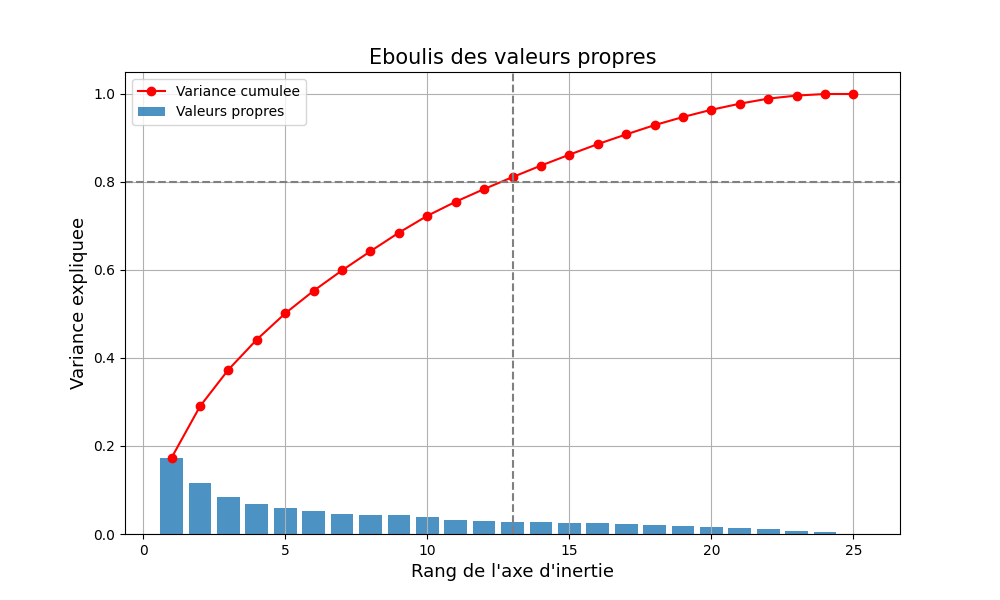

In [30]:
%matplot plt

Nous pouvons observer, grâce au graphique de l'éboulis des valeurs propres, que 13 composantes expliquent 80% de la variance. On va donc réduire les dimensions en conservant 80% de la variance. 

In [31]:
# Nouvelle instance ACP
pca_new = PCA(k=position, inputCol="scaledFeatures", 
              outputCol="ACP_reduced_features")
model_pca_new = pca_new.fit(scaled_df)
result_pca_new = model_pca_new.transform(scaled_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Nous allons maintenant sauvegarder les résultats des features réduites en format .csv.

#### d. Sauvegarde des résultats en format csv. 

In [32]:
results = result_pca_new.select("ACP_reduced_features")
results_pd = results.toPandas()
results_pd.to_csv(PATH + "/ACP_reduced_features.csv", index=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# Affichage du nombre de features
results_pd.loc[0, 'ACP_reduced_features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(13,)

In [34]:
results_pd.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                ACP_reduced_features
0  [9.744112743169179, -4.038122552329049, -17.04...
1  [-4.364989143326153, 23.370420159473596, 19.53...
2  [10.125509318132234, -3.538486110420308, -17.1...
3  [0.9073908531764704, 21.840704996367876, -3.71...
4  [2.775038988263456, 15.693467862577798, -7.404...